https://stackoverflow.com/questions/34933905/matplotlib-adding-subplots-to-a-subplot

https://stackoverflow.com/questions/43352931/matplotlib-subplot-imshow-plot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numba
import scipy.signal as spsig

from mpl_toolkits.axes_grid1 import make_axes_locatable

# plt.style.use('seaborn-pastel')
plt.rcParams['font.family'] = 'sans-serif'
COLOR = 'k'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.edgecolor'] = 'k'
SIZE = 15
plt.rcParams['font.size'] = SIZE
plt.rcParams['legend.fontsize'] = SIZE
plt.rcParams['figure.titlesize'] = SIZE
plt.rcParams['figure.dpi'] = 500
plt.rcParams['savefig.dpi'] = 500
# plt.rcParams['image.cmap'] = 'coolwarm'
# plt.rcParams['image.cmap'] = 'jet'
# plt.rcParams['image.cmap'] = 'Greys'

# Sunset ColorMap

In [2]:
from matplotlib import colors
from matplotlib import cm

def inter_from_256(x):
    return np.interp(x=x,xp=[0,255],fp=[0,1])

cdict = {
    'red':((0.0, inter_from_256(255), inter_from_256(255)),
           (1/350 * 90, inter_from_256(0), inter_from_256(0)),
           (1/350 * 265, inter_from_256(230), inter_from_256(230)),
           (1/350 * 350, inter_from_256(255), inter_from_256(255))),
    'green':((0.0, inter_from_256(255), inter_from_256(255)),
             (1/350 * 90, inter_from_256(0), inter_from_256(0)),
             (1/350 * 265, inter_from_256(86), inter_from_256(86)),
             (1/350 * 350, inter_from_256(128), inter_from_256(128))),
    'blue': ((0.0, inter_from_256(255), inter_from_256(255)),
             (1/350 * 90, inter_from_256(128), inter_from_256(128)),
             (1/350 * 265, inter_from_256(102), inter_from_256(102)),
             (1/350 * 350, inter_from_256(0), inter_from_256(0))),
}

new_cmap = colors.LinearSegmentedColormap('new_cmap',segmentdata=cdict)

# complex square function

In [3]:
@numba.vectorize(
    [numba.float64(numba.complex128),
     numba.float32(numba.complex64)])
def abs2(x):

    return x.real**2. + x.imag**2.

In [4]:
I_randDir = np.load("/Users/tommychin/Documents/research/Smallwood_research/paper/RightProj/I_randDir.npy")
I_randDir = np.sqrt(abs2(I_randDir))
I_randDir /= np.max(I_randDir)

I_iso = np.load("/Users/tommychin/Documents/research/Smallwood_research/paper/SimpleProj/I_iso.npy")

I_uniDir = np.load("/Users/tommychin/Documents/research/Smallwood_research/paper/RightProj/I_uniDir.npy")
I_uniDir = np.sqrt(abs2(I_uniDir))
I_uniDir /= np.max(I_uniDir)

I_uniDir_p0 = np.load("/Users/tommychin/Documents/research/Smallwood_research/paper/SimpleProj/I_uniDir_p0.npy")
unstrained = np.load("/Users/tommychin/Documents/research/Smallwood_research/paper/SimpleProj/unstrained.npy")


databox = np.array([I_randDir, I_iso, I_uniDir, I_uniDir_p0])

In [5]:
np.shape(unstrained)

(500, 500)

In [6]:
res = 500

Delta_ZPL_0 = 406.83  # 406 THz  Meesala
lambda_SO_gs = 46e-3  # 46 GHz  Meesala
lambda_SO_es = 255e-3  # 255 GHz  Meesala

nu_t_min = Delta_ZPL_0-lambda_SO_es+lambda_SO_gs - 3
nu_t_max = Delta_ZPL_0-lambda_SO_es+lambda_SO_gs + 3

nu_t = np.linspace(nu_t_min, nu_t_max, res)
nu_tau = np.linspace(-nu_t_max, -nu_t_min, res)

minPlt = nu_t_min   # THz
maxPlt = nu_t_max

minInd_t = np.argmin(np.abs(nu_t-minPlt))
maxInd_t = np.argmin(np.abs(nu_t-maxPlt))

minInd_tau = np.argmin(np.abs(nu_tau+maxPlt))
maxInd_tau = np.argmin(np.abs(nu_tau+minPlt))

In [7]:
def findMax(I_random6_proj, ax):
    n = 30  # the larger n is, the smoother curve will be
    b = [1.0 / n] * n
    a = 1.

    I_random6_proj_fill_amp = spsig.filtfilt(b, a, np.sqrt(abs2(I_random6_proj)))

    peaks, _ = spsig.find_peaks(I_random6_proj_fill_amp)
    results_half = spsig.peak_widths(I_random6_proj_fill_amp,
                                     peaks,
                                     rel_height=0.5)

#     unstrained = np.sum(np.sqrt(abs2(rho(nu_t_mesh, nu_tau_mesh)
#                                     )), axis=0)  # unstrained
#     unstrained *= np.max(I_random6_proj_fill_amp) / np.max(unstrained)
    
    colors =  plt.cm.tab20( np.arange(4).astype(int) )

#     figproj = plt.figure(figsize=(8,3))
#     ax.plot(nu_t, unstrained, label='unstrained', c='C0')
    ax.plot(nu_t, I_random6_proj, c=colors[3])
    ax.plot(nu_t, I_random6_proj_fill_amp, c='C1',
             label='strained')  # smooth by filter

    for i in range(len(peaks)):

        if i == np.argmax(results_half[0]):
            color='C3'
            Alpha=1
#         else:
#             color='C4'
#             Alpha=0.5

            ax.plot(nu_t[peaks[i]],
                     I_random6_proj_fill_amp[peaks[i]],
                     "x",
                     c='C2',
                     alpha=Alpha)
            ax.hlines(results_half[1][i],
                       results_half[2][i] / res * (nu_t_max - nu_t_min) + nu_t_min,
                       results_half[3][i] / res * (nu_t_max - nu_t_min) + nu_t_min,
                       color="C2",
                       alpha=Alpha)
            ax.text(nu_t[peaks[i]],
                     results_half[1][i],
                     f'FWHM={results_half[0][i]/res*(nu_t_max-nu_t_min) :.2f}',
                     c=color,
                     alpha=Alpha,
                     ha='center',
                     va='top')
#     ax.legend(labelcolor='k', loc='best', fancybox=True, framealpha=0)
    return

In [8]:
def projPlot(DataBox=databox, 
             figure_size=(11, 14), 
             figure_shape=[2, 2], 
             share_x_axis=True, 
             share_y_axis=True, 
             shared_x_label=r'Third-order frequency, $\nu_t$ (THz)', 
             shared_x_label_x_position=0.5, 
             shared_x_label_y_position=0.09, 
             shared_y_label=r'First-order frequency, $\nu_\tau$ (THz)', 
             shared_y_label_x_position=0.04, 
             shared_y_label_y_position=0.5, 
             shared_title=None, 
             shared_title_x_position=0.515, 
             shared_title_y_position=0.93, 
             outer_hgap=0.005, 
             outer_vgap=0.05, 
             titles = [r'$\left |S_{randDir} (\nu_t, \nu_\tau) \right |$', 
              r'$\left |S_{iso} (\nu_t, \nu_\tau) \right |$', 
              r'$\left |S_{uniDir} (\nu_t, \nu_\tau) \right |$', 
              r'$\left |S_{uniDir_{p0}} (\nu_t, \nu_\tau) \right |$']
            ):

    fig = plt.figure(figsize=figure_size)

    outer = gridspec.GridSpec(figure_shape[0],  # row
                              figure_shape[1],  # column, 
                              wspace=outer_hgap, 
                              hspace=outer_vgap)

    unstrained_x = np.sum(unstrained, axis=0)
#     unstrained_y = np.sum(unstrained, axis=1)
    unstrained_x /= max(unstrained_x)
#     unstrained_y /= max(unstrained_y)


    for i in range(4):
        inner = gridspec.GridSpecFromSubplotSpec(1, 1,
                        subplot_spec=outer[i])

        ax = plt.Subplot(fig, inner[0])

        Z = DataBox[i]

        x = np.sum(Z, axis=0)
    #     y = np.sum(Z, axis=1)

        x /= max(x)
    #     y /= max(y)

        EXTENT=(minPlt, maxPlt, -maxPlt, -minPlt)
        im = ax.imshow(Z, origin='lower', extent=EXTENT, cmap=new_cmap)

        # create new axes on the right and on the top of the current axes.
        divider = make_axes_locatable(ax)
        axtop = divider.append_axes("top", size="25%", pad=0.05, sharex=ax)
    #     axright = divider.append_axes("right", size="25%", pad=0.05, sharey=ax)

        label='arb. units'
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(im, cax=cax)

        axtop.spines['top'].set_visible(False)
        axtop.spines['right'].set_visible(False)

        if i < np.prod(figure_shape) - figure_shape[1]:

            ax.get_xaxis().set_visible(False)
    #         axright.get_xaxis().set_visible(False)

        if i % figure_shape[1]:

            ax.get_yaxis().set_visible(False)
            axtop.get_yaxis().set_visible(False)
            axtop.spines['left'].set_visible(False)

            if label is not None:
                plt.ylabel(label)

        if (i+1) % figure_shape[1]:

            cax.set_visible(False)


        #plot to the new axes
        axtop.plot(nu_t[minInd_t: maxInd_t+1], unstrained_x, label='unstrained')
        axtop.plot(nu_t[minInd_t: maxInd_t+1], x)
        
        findMax(x, axtop)

    #     axright.plot(unstrained_y, nu_tau[minInd_tau: maxInd_tau+1])
    #     axright.plot(y, nu_tau[minInd_tau: maxInd_tau+1])
        axtop.get_xaxis().set_visible(False)
    #     axright.get_yaxis().set_visible(False)

        axtop.set_title(titles[i])
        if i==0:
            axtop.legend(labelcolor='k', loc='best', fancybox=True, framealpha=0)


        if shared_title != None:  # shared x label
            fig.suptitle(x=shared_title_x_position,
                         y=shared_title_y_position,
                         t=shared_title,
                         ha='center',
                         size=1.5 * SIZE)

        if shared_x_label != None:  # shared x label
            fig.text(x=shared_x_label_x_position,
                     y=shared_x_label_y_position,
                     s=shared_x_label,
                     ha='center')

        if shared_y_label != None:  # shared y label
            fig.text(x=shared_y_label_x_position,
                     y=shared_y_label_y_position,
                     s=shared_y_label,
                     va='center',
                     rotation='vertical')

        #adjust margins
    #     axright.margins(y=0)
        axtop.margins(x=0)

        fig.add_subplot(ax)

    plt.show()
    return fig

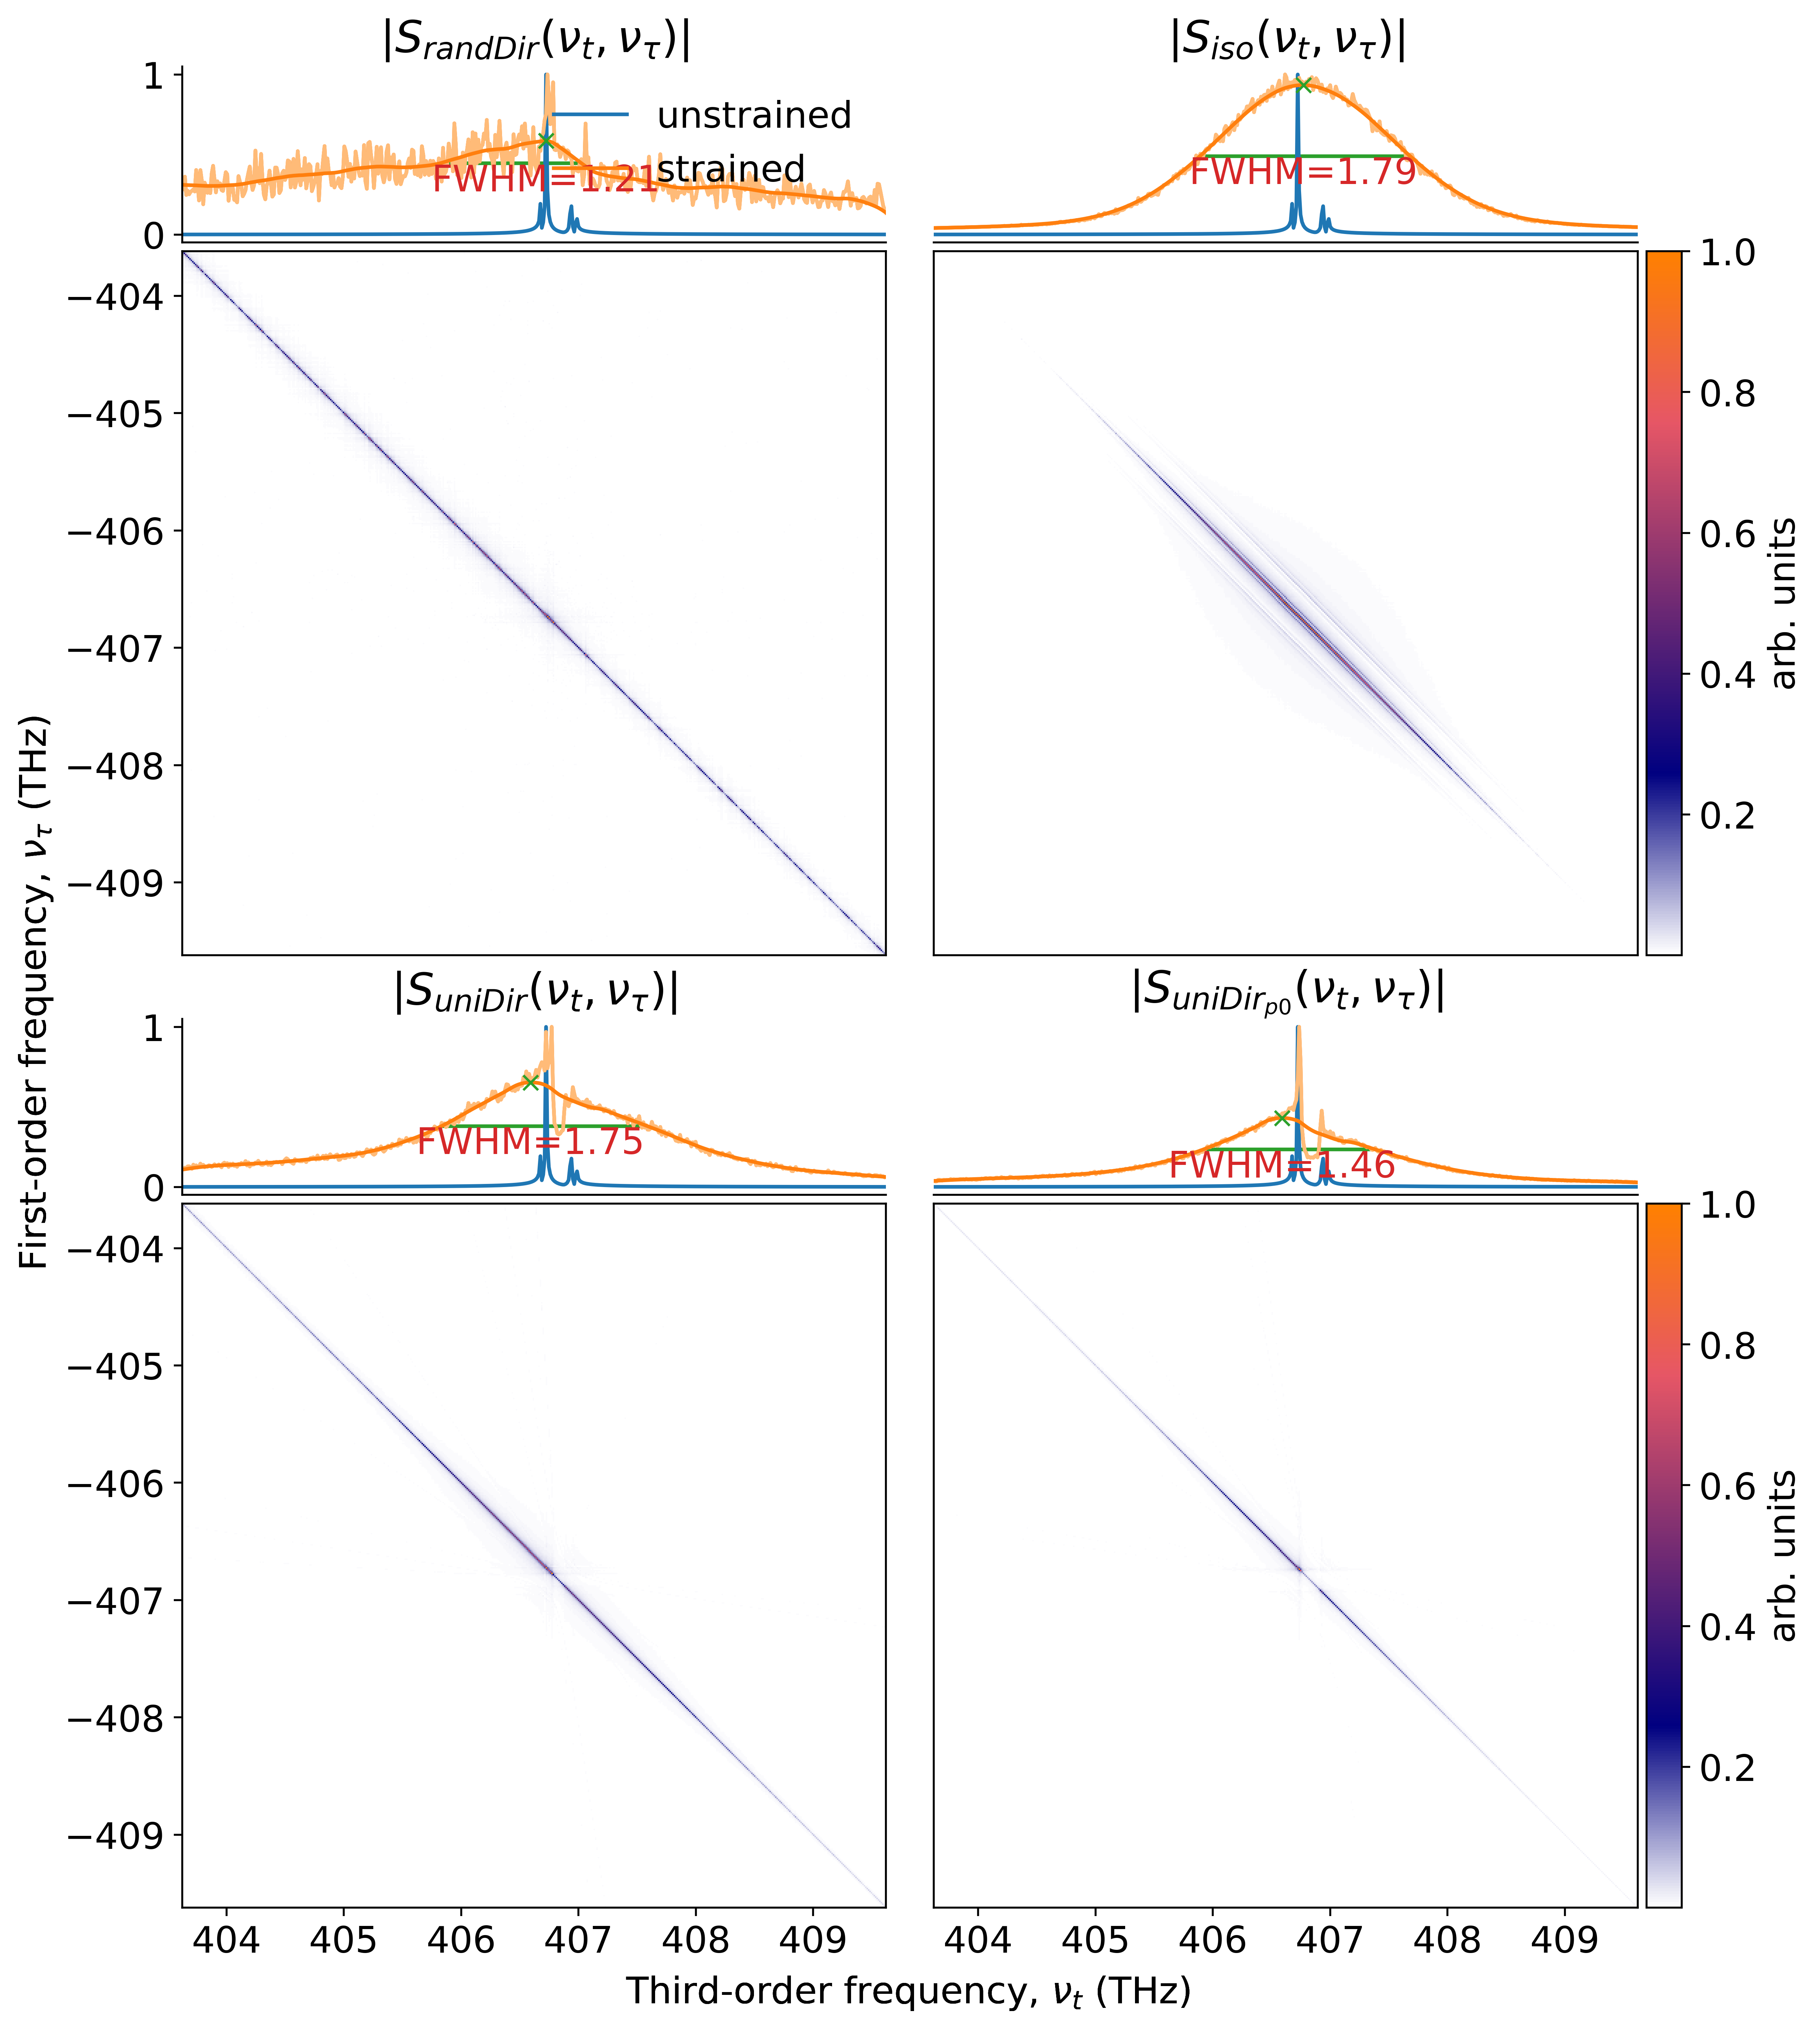

In [9]:
fig = projPlot()

In [10]:
fig.savefig("/Users/tommychin/Documents/research/Smallwood_research/paper/RightProj/OtherModels2.eps", 
                 format='eps', 
                 bbox_inches='tight')

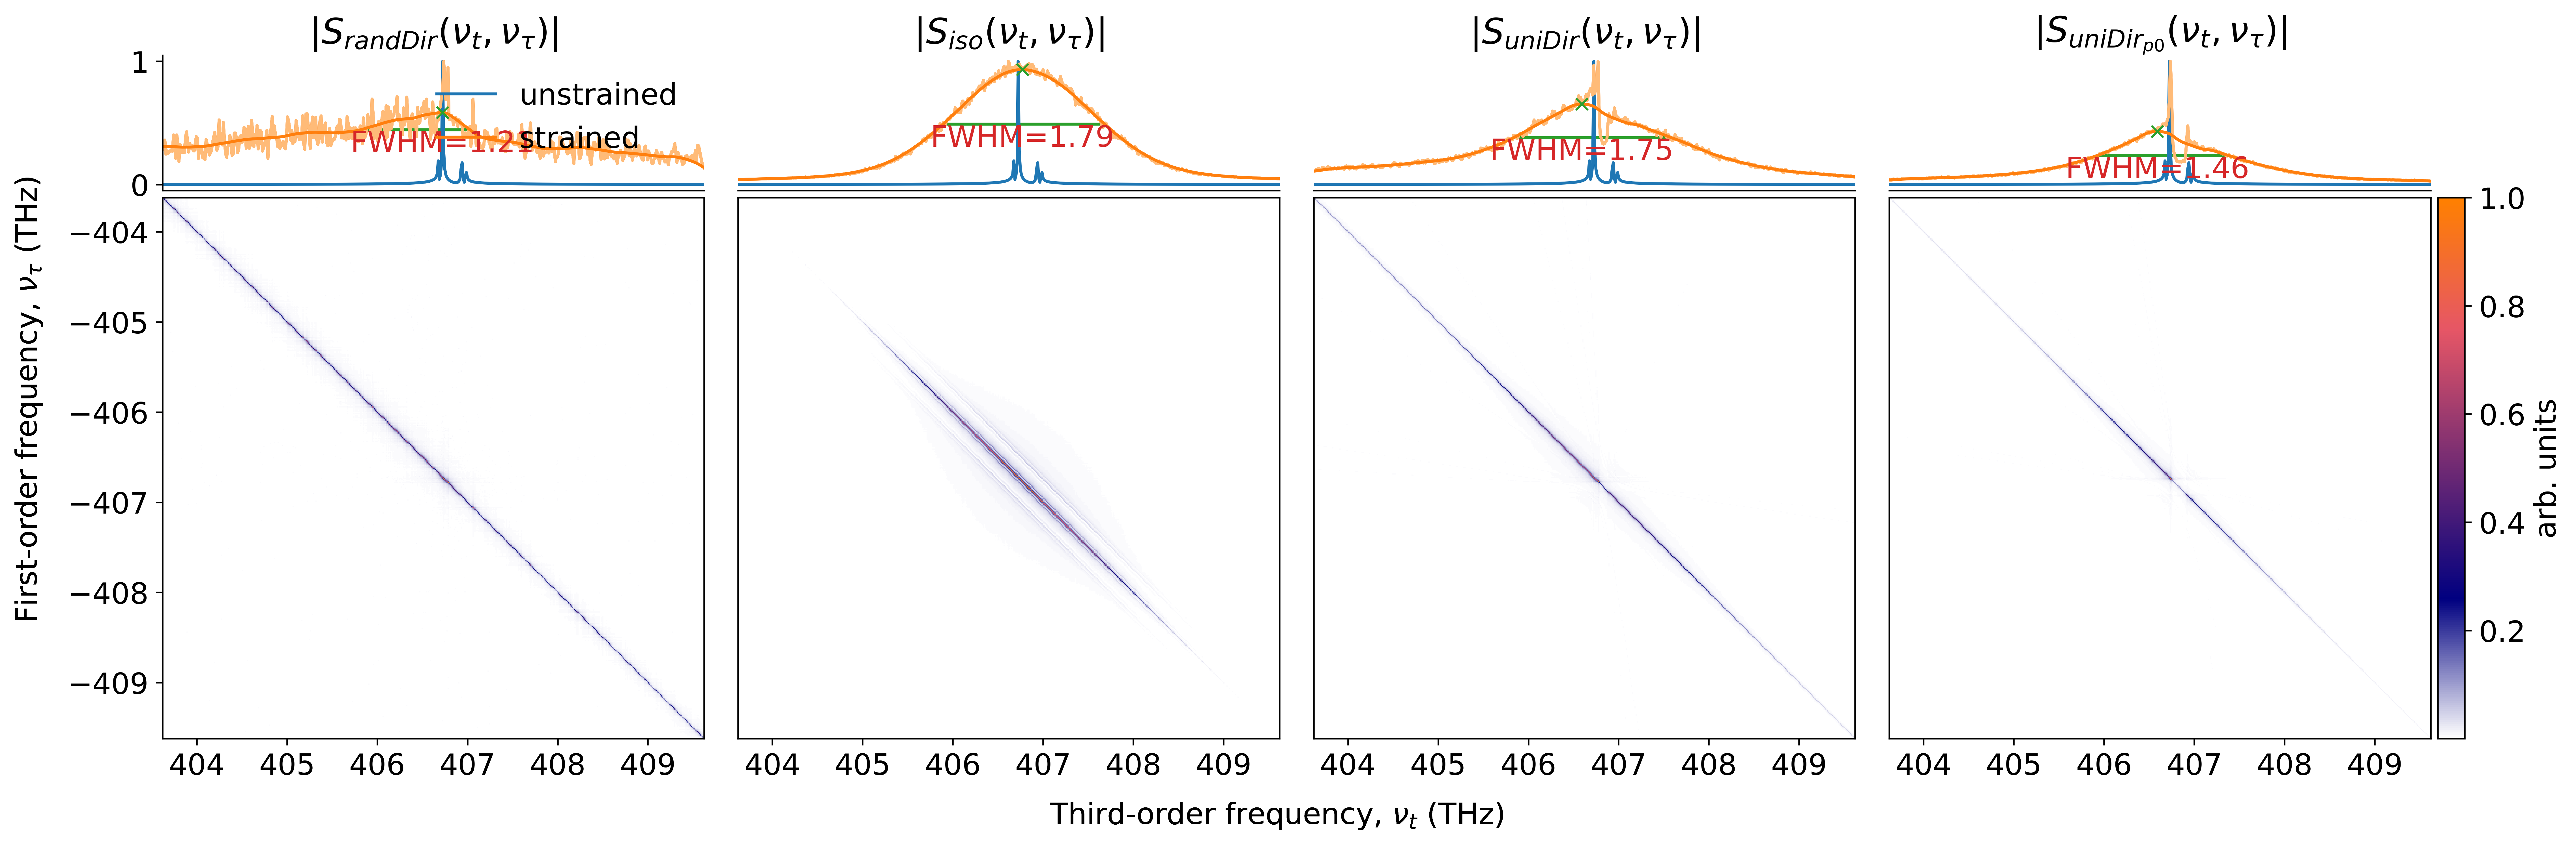

In [11]:
fig2 = projPlot(figure_shape=[1, 4],
                figure_size=(21, 8),
                shared_x_label_y_position=0.125, 
                shared_y_label_x_position=0.075,
                outer_hgap=0.0001,
)

In [12]:
fig2.savefig("/Users/tommychin/Documents/research/Smallwood_research/paper/RightProj/OtherModels3.eps", 
                 format='eps', 
                 bbox_inches='tight')